Nathan Dang

02/04/2020

DSCI225 - Applied Machine Learning

Instructor: Prof. Basye

# Lab 3 - Several Approaches to a Tricky Regression Problem

The purpose of this notebook is to try to get a better understanding of Logistic Regression function

## Get the data

To begin with, let's import some important libraries

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

To begin with, we build two training sets, one with just a bunch of points X chosen randomly between +/- 10 and their correct y values and one where the y values have added Gaussian noise like the examples earlier in the chapter. Use a variance of 0.15 for your noise by multiplying the result of np.random.randn() by 0.15. Thus, we'll have one X and two different labels (y's), we'll call the them clean labels and the noisy labels. 

In [2]:
X = 20 * np.random.rand(200, 1) - 10
y_clean = 1 / (1 + np.exp(-X))
y_noisy = 1 / (1 + np.exp(-X + 0.15 * np.random.randn(200, 1)))

In [3]:
print(X.shape)
print(y_clean.shape)
print(y_noisy.shape)

(200, 1)
(200, 1)
(200, 1)


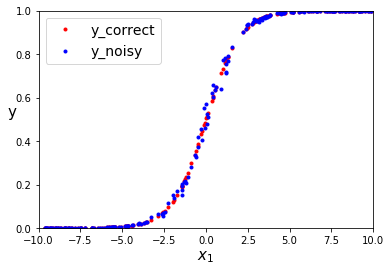

In [4]:
plt.plot(X, y_clean, "r.", linewidth=2, label="y_correct")
plt.plot(X, y_noisy, "b.", linewidth=2, label="y_noisy")
plt.xlabel("$x_1$", fontsize=15)
plt.ylabel("y", rotation=0, fontsize=15)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-10, 10, 0, 1])
plt.show()

## Linear Regression

First, we begin by training two linear models (one each on the clean and noisy labels) and measuring their RMSE - these will be our baseline models. In all of what follows, we'll be building and training pairs of (clean, noisy) models and evaluating both.

Train the linear model for the clean set including visualisation and the RMSE score of the model

In [5]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y_clean)
y_clean_predict = lin_reg.predict(X)

In [6]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_clean, y_clean_predict)
print(np.sqrt(mse))

0.1509499191965484


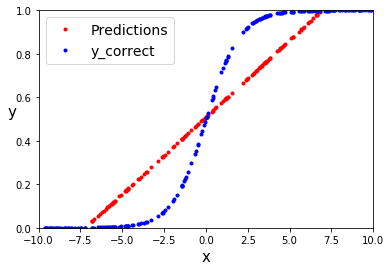

In [7]:
plt.plot(X, y_clean_predict, "r.", linewidth=2, label="Predictions")
plt.plot(X, y_clean, "b.", linewidth=2, label="y_correct")
plt.xlabel("x", fontsize=15)
plt.ylabel("y", rotation=0, fontsize=15)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-10, 10, 0, 1])
plt.show()

Train the linear model for the noisy set including visualisation and the RMSE score of the model

In [8]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y_noisy)
y_noisy_predict = lin_reg.predict(X)

In [9]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_noisy, y_noisy_predict)
print(np.sqrt(mse))

0.15136160024081743


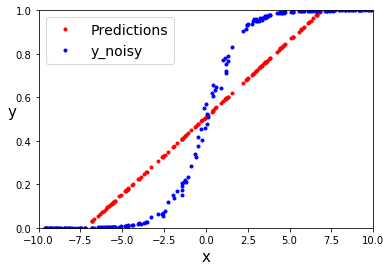

In [10]:
plt.plot(X, y_noisy_predict, "r.", linewidth=2, label="Predictions")
plt.plot(X, y_noisy, "b.", linewidth=2, label="y_noisy")
plt.xlabel("x", fontsize=15)
plt.ylabel("y", rotation=0, fontsize=15)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-10, 10, 0, 1])
plt.show()

<b>Observation: </b> the RMSE scores for both are not very much different from each other, we can also see from the two graphs above that the predictions are very similar. We will use these as our baseline 

## Polynomial Regression

This method builds polynomial models given a degree parameter 

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
def poly_train(regression, X_train, y_train, degree_param):
    # Generate a new feature matrix consisting of all polynomial combinations of the features 
    # with degree less than or equal to the specified degree.
    poly = PolynomialFeatures(degree = degree_param, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    reg = regression.fit(X_train_poly, y_train)
    
    y_predict = reg.predict(X_train_poly)
    rmse = np.sqrt(mean_squared_error(y_train, y_predict))
    
    # for visualisation
    X_model = np.linspace(-10, 10, 200).reshape(200, 1) 
    X_model_poly = poly.fit_transform(X_model)
    y_model_predict = reg.predict(X_model_poly)
    return X_model, y_model_predict, rmse

In [12]:
def draw_model(model_name, X_model, y, y_predict, rmse):
    plt.figure(figsize=(12, 6))
    plt.plot(X, y, "b.", markersize=10, alpha=0.5)
    plt.plot(X_model, y_predict, "r-", linewidth=2, label="Predictions")
    plt.xlabel("x", fontsize=15)
    plt.ylabel("y", rotation=0, fontsize=15)
    plt.title(model_name)
    plt.legend(loc="upper left", fontsize=14)

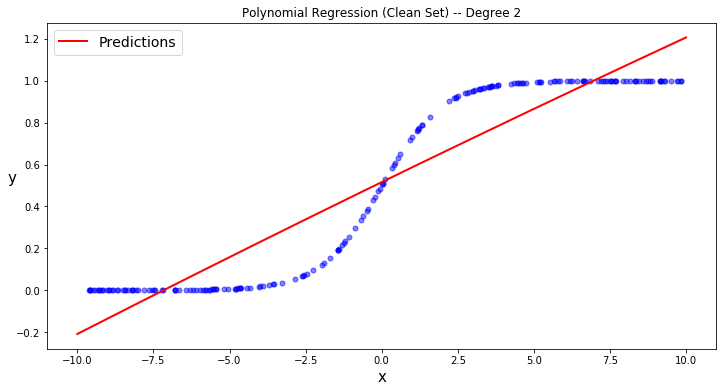

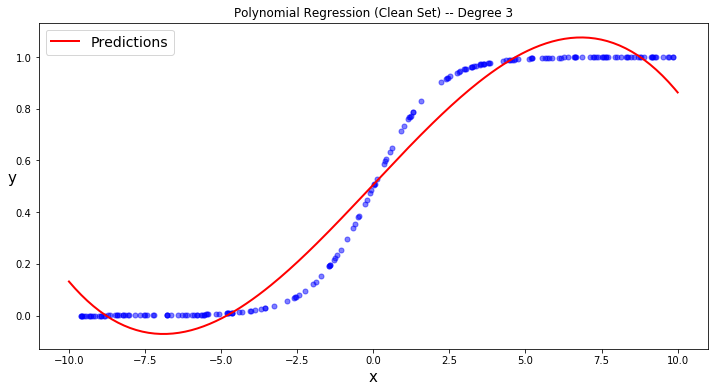

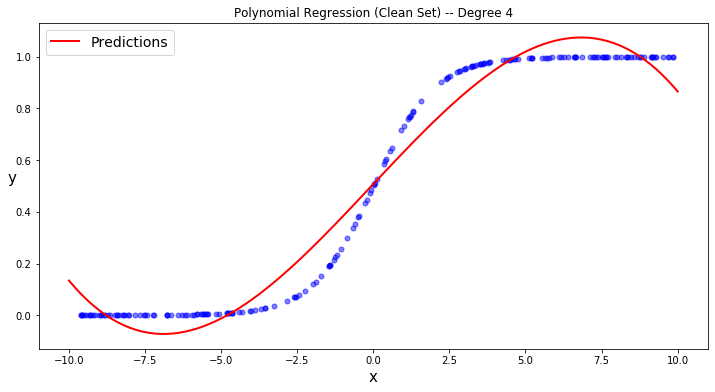

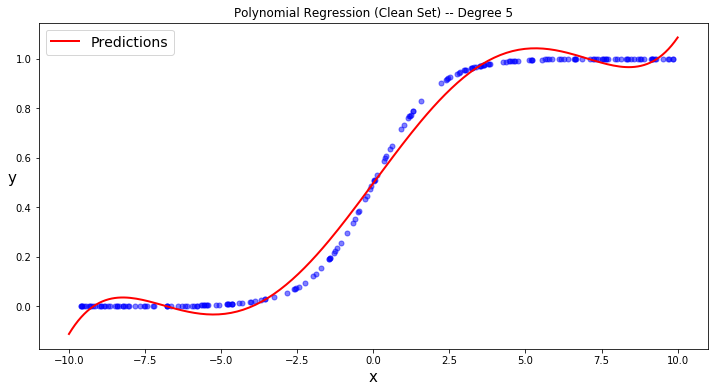

In [13]:
for i in range(2, 6):
    X_model, y_model_predict, rmse = poly_train(LinearRegression(), X, y_clean, i)
    draw_model("Polynomial Regression (Clean Set) -- Degree " + str(i), X_model, y_clean, y_model_predict, rmse)

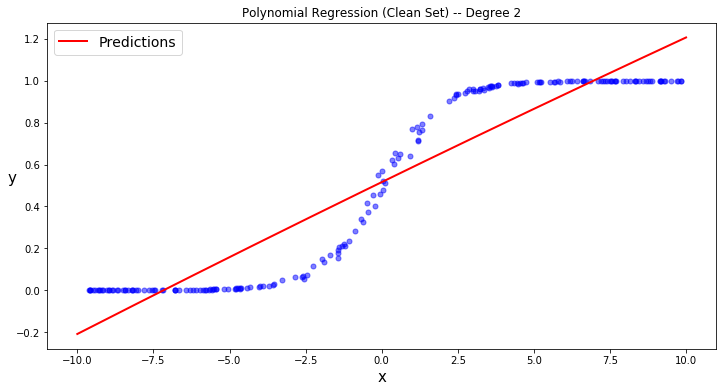

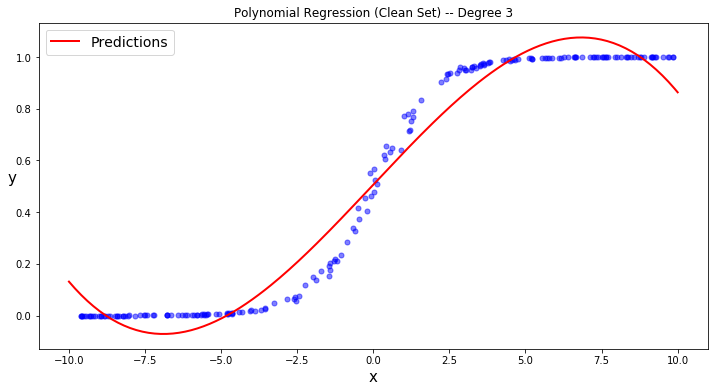

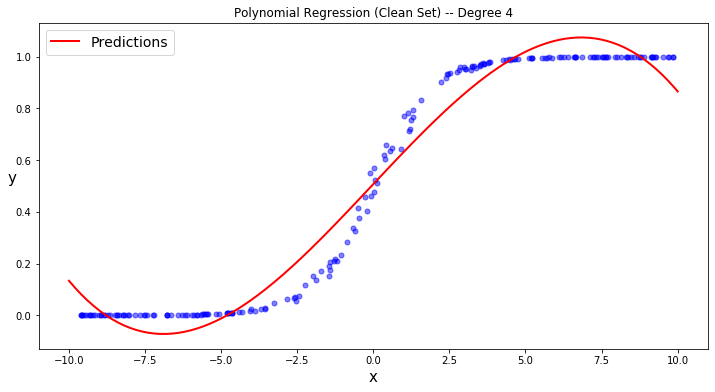

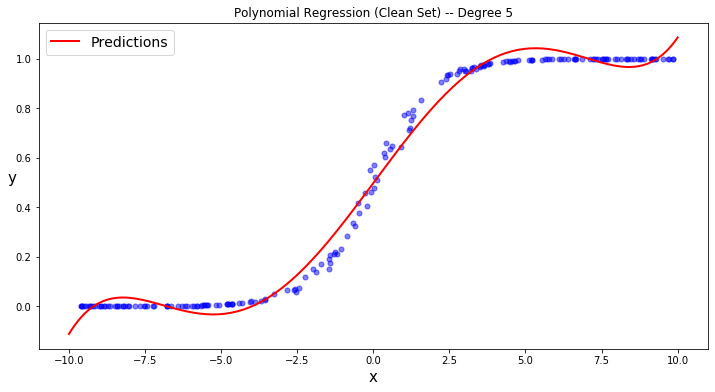

In [14]:
for i in range(2, 6):
    X_model, y_model_predict, rmse = poly_train(LinearRegression(), X, y_noisy, i)
    draw_model("Polynomial Regression (Clean Set) -- Degree " + str(i), X_model, y_noisy, y_model_predict, rmse)